In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-02_16-07_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.16453135536075522

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

ES       0.25
NQ       0.25
YM       0.25
GC       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES     1367.90
GC     -458.24
NQ    38875.00
YM    23884.20
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

63668.86

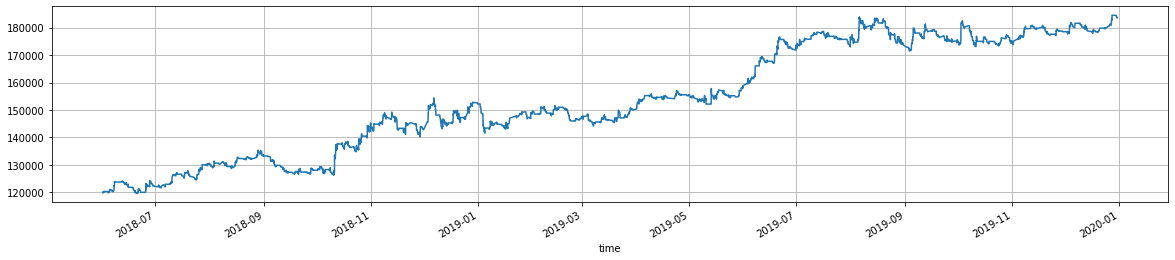

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     677
 GC    1273
 NQ    1800
 YM     699
 Name: action, dtype: int64,
 4449)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.643204
 GC    3.089806
 NQ    4.368932
 YM    1.696602
 Name: action, dtype: float64,
 10.798543689320388)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1421.70
GC    3080.66
NQ    3780.00
YM    1467.90
Name: commission, dtype: float64

In [16]:
df.commission.sum()

9750.26

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.38,-0.72,427.08,-258.27,1.65,2.16,636.0
NQ,0.42,43.19,442.23,-241.83,1.83,45.48,900.0
ES,0.39,4.05,799.84,-512.25,1.56,-0.53,338.0
YM,0.40,68.44,706.47,-364.08,1.94,64.14,349.0
total,0.40,28.64,533.67,-307.29,1.74,29.09,2223.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.091230,0.173372,0.394069,0.745482
GC,0.091230,1.000000,0.051637,0.064449,0.416622
NQ,0.173372,0.051637,1.000000,0.156625,0.576854
YM,0.394069,0.064449,0.156625,1.000000,0.667685
total,0.745482,0.416622,0.576854,0.667685,1.000000


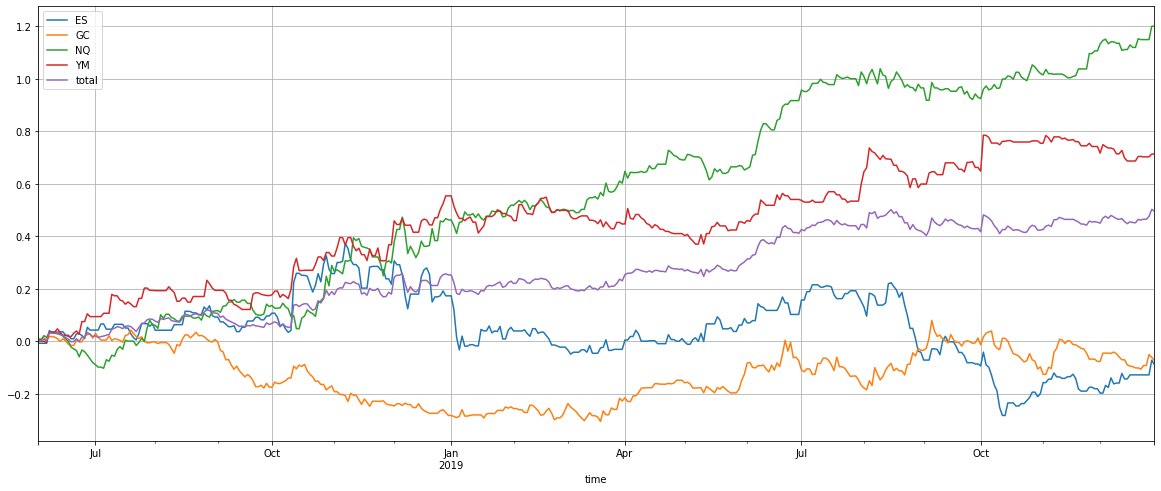

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

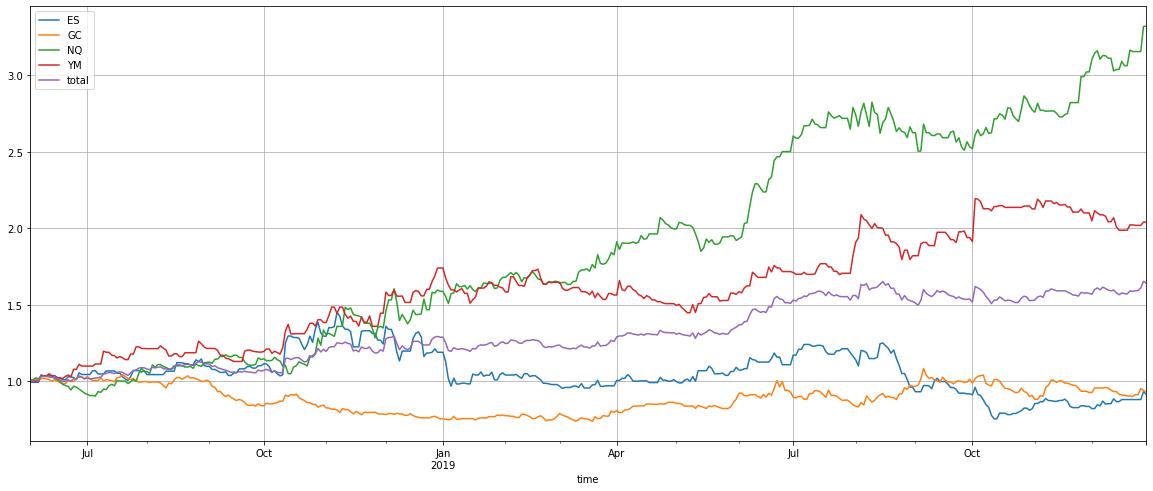

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,-0.052833,-0.043894,1.083764,0.546660,0.353981
Cumulative returns,-0.084919,-0.070758,2.321177,1.040073,0.641255
Annual volatility,0.409938,0.268200,0.341667,0.322587,0.208096
Sharpe ratio,0.068033,-0.034835,2.319795,1.509545,1.559502
Calmar ratio,-0.110024,-0.149502,7.583799,3.254340,3.778292
Stability,0.245565,0.004325,0.968200,0.894435,0.926131
Max drawdown,-0.480189,-0.293601,-0.142905,-0.167979,-0.093688
Omega ratio,1.014998,0.993700,1.566955,1.399570,1.346931
Sortino ratio,0.108925,-0.056438,4.402661,3.084338,2.881096
Skew,1.374188,0.902708,0.915104,2.048073,1.571155


In [23]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,4.39,1.24,-7.77,9.88,1.83
2018-07-31,2.43,-1.40,15.40,10.49,6.79
2018-08-31,2.59,0.90,5.51,0.02,2.45
2018-09-30,0.42,-16.63,1.67,-1.98,-4.28
2018-10-31,17.51,0.52,16.95,16.27,13.34
2018-11-30,-3.97,-7.00,0.94,4.39,-0.96
2018-12-31,-4.33,-3.94,17.81,20.45,7.58
2019-01-31,-11.28,3.35,5.76,-7.50,-2.34
2019-02-28,-7.28,-1.10,-1.58,2.31,-1.84


In [24]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        -8.0
GC        -7.0
NQ       232.0
YM       104.0
total     64.0
dtype: float64

In [25]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:43:00,YM,BUY,26059.00,4410.80
2018-10-11 04:23:00,ES,BUY,2766.50,4245.80
2019-06-20 03:04:00,GC,SELL,1392.40,3105.16
2018-10-31 15:48:00,NQ,SELL,6989.50,2965.80
2018-12-03 15:47:00,YM,SELL,25943.00,2855.80
...,...,...,...,...
2018-12-21 00:01:30,ES,BUY,2488.75,-1391.70
2018-10-30 14:53:30,ES,BUY,2663.00,-1491.70
2018-12-21 16:16:00,ES,BUY,2502.50,-1516.70


In [26]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2018-10-11,0.201107,0.046527,0.004327,0.090940,0.085725
2019-10-02,0.053610,0.030688,0.036273,0.147027,0.066900
2018-12-03,0.093193,-0.003989,0.082273,0.095193,0.066668
2019-08-05,0.091387,0.034849,0.035793,0.078747,0.060194
2019-09-05,0.043610,0.068677,0.070387,0.004887,0.046890
...,...,...,...,...,...
2019-01-02,-0.050973,-0.003495,-0.021780,-0.037973,-0.028555
2018-12-10,-0.049170,-0.005323,-0.080313,-0.000780,-0.033896
2018-11-15,-0.074170,-0.016989,-0.029340,-0.024280,-0.036195
